In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
import math

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
data_split

[[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 9.0, 0.0],
  [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 8.0, 1.0],
  [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 7.0, 2.0],
  [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 6.0, 2.0],
  [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 5.0, 2.0],
  [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 4.0, 2.0],
  [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 3.0, 2.0],
  [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 2.0, 2.0],
  [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 1.0, 3.0],
  [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 0.0, 4.0]],
 [[10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 12.0, 0.0],
  [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 11.0, 0.0],
  [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 10.0, 0.0],
  [13.0, 0.353154082, 0.597895409, 0.2172971, 0.265631153, 9.0, 1.0],
  [

In [10]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.75*num_episodes)
num_val = int(0.125*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [11]:
def splitDataIntoChunks3DWithStateInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    arr = [reading[1], reading[2], reading[3], reading[4], reading[6]]
                    episode_chunk.append(arr)
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][5])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [12]:
def splitDataIntoChunks3DNoStateInfo(data, chunk_size):
    X_split = []
    y_split = []
    time_split = []
    for episode in data:
        for order in range(0, len(episode)):
            diff = len(episode) - order
            if diff > chunk_size:
                episode_chunk = []
                for i in range(0, chunk_size):
                    reading = episode[order+i]
                    episode_chunk.append(reading[1:5])
                X_split.append(episode_chunk)
                y_split.append(episode[order+chunk_size][5])
                time_split.append(int(episode[order+chunk_size][0]))
    return (X_split, y_split, time_split)

In [13]:
#set random seed 
tf.random.set_seed(42)

In [14]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

### Attempt 1: Timestep = 4, No dilation, Without Machine State Info

In [15]:
(trainX_4step, trainY_4step, trainTime_4step) = splitDataIntoChunks3DNoStateInfo(train_data, 4)
(valX_4step, valY_4step, valTime_4step) = splitDataIntoChunks3DNoStateInfo(val_data, 4)
(testX_4step, testY_4step, testTime_4step) = splitDataIntoChunks3DNoStateInfo(test_data, 4)

In [16]:
#check shape of X (training)
trainX_4step_arr = np.array(trainX_4step)
trainX_4step_arr.shape

(4022, 4, 4)

In [17]:
#check shape of y (training)
trainY_4step_arr = np.array(trainY_4step)
trainY_4step_arr = trainY_4step_arr.reshape(-1, 1)
trainY_4step_arr.shape

(4022, 1)

In [18]:
#check shape of X (validation)
valX_4step_arr = np.array(valX_4step)
valX_4step_arr.shape

(635, 4, 4)

In [19]:
#check shape of y (validation)
valY_4step_arr = np.array(valY_4step)
valY_4step_arr = valY_4step_arr.reshape(-1, 1)
valY_4step_arr.shape

(635, 1)

In [20]:
#configure architecture 
model1 = models.Sequential()
model1.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 4), padding="same"))
model1.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model1.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model1.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dense(100, activation='relu'))
model1.add(layers.Dense(1, activation='relu'))

In [21]:
adam = keras.optimizers.Adam(learning_rate=0.001)
model1.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [27]:
fileName1 = "CNN_stateTest_noStateInfo.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName1,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [28]:
learning_model1 = model1.fit(trainX_4step_arr, trainY_4step_arr, epochs=500, batch_size=32, validation_data=(valX_4step_arr, valY_4step_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 3s 10ms/step - loss: 23.9076 - mean_squared_error: 23.9076 - val_loss: 11.6124 - val_mean_squared_error: 11.6124
Epoch 2/500
126/126 [==============================] - 1s 7ms/step - loss: 19.6569 - mean_squared_error: 19.6569 - val_loss: 11.4242 - val_mean_squared_error: 11.4242
Epoch 3/500
126/126 [==============================] - 1s 5ms/step - loss: 19.1778 - mean_squared_error: 19.1778 - val_loss: 11.1962 - val_mean_squared_error: 11.1962
Epoch 4/500
126/126 [==============================] - 1s 5ms/step - loss: 19.2013 - mean_squared_error: 19.2013 - val_loss: 11.0856 - val_mean_squared_error: 11.0856
Epoch 5/500
126/126 [==============================] - 1s 8ms/step - loss: 19.1009 - mean_squared_error: 19.1009 - val_loss: 10.8884 - val_mean_squared_error: 10.8884
Epoch 6/500
126/126 [==============================] - 1s 6ms/step - loss: 18.5771 - mean_squared_error: 18.5771 - val_loss: 10.7401 - val_mean_squared_error: 10.74

Epoch 99/500
126/126 [==============================] - 1s 7ms/step - loss: 16.2478 - mean_squared_error: 16.2478 - val_loss: 9.5485 - val_mean_squared_error: 9.5485
Epoch 100/500
126/126 [==============================] - 1s 6ms/step - loss: 16.2227 - mean_squared_error: 16.2227 - val_loss: 9.7116 - val_mean_squared_error: 9.7116
Epoch 101/500
126/126 [==============================] - 1s 5ms/step - loss: 16.3232 - mean_squared_error: 16.3232 - val_loss: 9.6343 - val_mean_squared_error: 9.6343
Epoch 102/500
126/126 [==============================] - 1s 6ms/step - loss: 16.2397 - mean_squared_error: 16.2397 - val_loss: 9.5675 - val_mean_squared_error: 9.5675
Epoch 103/500
126/126 [==============================] - 1s 6ms/step - loss: 16.2991 - mean_squared_error: 16.2991 - val_loss: 9.6781 - val_mean_squared_error: 9.6781
Epoch 104/500
126/126 [==============================] - 1s 5ms/step - loss: 16.1441 - mean_squared_error: 16.1441 - val_loss: 9.6905 - val_mean_squared_error: 9.6905

126/126 [==============================] - 1s 7ms/step - loss: 15.7140 - mean_squared_error: 15.7140 - val_loss: 9.7306 - val_mean_squared_error: 9.7306
Epoch 149/500
126/126 [==============================] - 1s 7ms/step - loss: 15.7409 - mean_squared_error: 15.7409 - val_loss: 9.6522 - val_mean_squared_error: 9.6522
Epoch 150/500
126/126 [==============================] - 1s 8ms/step - loss: 15.6982 - mean_squared_error: 15.6982 - val_loss: 9.7653 - val_mean_squared_error: 9.7653
Epoch 151/500
126/126 [==============================] - 1s 7ms/step - loss: 15.7242 - mean_squared_error: 15.7242 - val_loss: 9.9712 - val_mean_squared_error: 9.9712
Epoch 152/500
126/126 [==============================] - 1s 6ms/step - loss: 15.6427 - mean_squared_error: 15.6427 - val_loss: 9.7936 - val_mean_squared_error: 9.7936
Epoch 153/500
126/126 [==============================] - 1s 7ms/step - loss: 15.5988 - mean_squared_error: 15.5988 - val_loss: 9.8181 - val_mean_squared_error: 9.8181
Epoch 154/50

Epoch 197/500
126/126 [==============================] - 1s 5ms/step - loss: 14.9650 - mean_squared_error: 14.9650 - val_loss: 10.2940 - val_mean_squared_error: 10.2940
Epoch 198/500
126/126 [==============================] - 1s 5ms/step - loss: 14.9271 - mean_squared_error: 14.9271 - val_loss: 10.1550 - val_mean_squared_error: 10.1550
Epoch 199/500
126/126 [==============================] - 1s 5ms/step - loss: 15.1361 - mean_squared_error: 15.1361 - val_loss: 10.0896 - val_mean_squared_error: 10.0896
Epoch 200/500
126/126 [==============================] - 1s 5ms/step - loss: 14.9523 - mean_squared_error: 14.9523 - val_loss: 9.9645 - val_mean_squared_error: 9.9645
Epoch 201/500
126/126 [==============================] - 1s 5ms/step - loss: 15.0464 - mean_squared_error: 15.0464 - val_loss: 10.1066 - val_mean_squared_error: 10.1066
Epoch 202/500
126/126 [==============================] - 1s 5ms/step - loss: 15.2663 - mean_squared_error: 15.2663 - val_loss: 10.1600 - val_mean_squared_err

126/126 [==============================] - 1s 5ms/step - loss: 14.3193 - mean_squared_error: 14.3193 - val_loss: 10.5297 - val_mean_squared_error: 10.5297
Epoch 294/500
126/126 [==============================] - 1s 6ms/step - loss: 14.2511 - mean_squared_error: 14.2511 - val_loss: 10.4925 - val_mean_squared_error: 10.4925
Epoch 295/500
126/126 [==============================] - 1s 5ms/step - loss: 14.2955 - mean_squared_error: 14.2955 - val_loss: 10.4569 - val_mean_squared_error: 10.4569
Epoch 296/500
126/126 [==============================] - 1s 5ms/step - loss: 14.2944 - mean_squared_error: 14.2944 - val_loss: 10.6138 - val_mean_squared_error: 10.6138
Epoch 297/500
126/126 [==============================] - 1s 5ms/step - loss: 14.3020 - mean_squared_error: 14.3020 - val_loss: 10.4990 - val_mean_squared_error: 10.4990
Epoch 298/500
126/126 [==============================] - 1s 5ms/step - loss: 14.3849 - mean_squared_error: 14.3849 - val_loss: 10.9109 - val_mean_squared_error: 10.9109


126/126 [==============================] - 1s 6ms/step - loss: 13.1378 - mean_squared_error: 13.1378 - val_loss: 10.9558 - val_mean_squared_error: 10.9558
Epoch 390/500
126/126 [==============================] - 1s 6ms/step - loss: 13.4170 - mean_squared_error: 13.4170 - val_loss: 10.5814 - val_mean_squared_error: 10.5814
Epoch 391/500
126/126 [==============================] - 1s 6ms/step - loss: 13.6964 - mean_squared_error: 13.6964 - val_loss: 11.0969 - val_mean_squared_error: 11.0969
Epoch 392/500
126/126 [==============================] - 1s 5ms/step - loss: 13.1929 - mean_squared_error: 13.1929 - val_loss: 10.8840 - val_mean_squared_error: 10.8840
Epoch 393/500
126/126 [==============================] - 1s 6ms/step - loss: 14.0369 - mean_squared_error: 14.0369 - val_loss: 10.8568 - val_mean_squared_error: 10.8568
Epoch 394/500
126/126 [==============================] - 1s 5ms/step - loss: 13.4017 - mean_squared_error: 13.4017 - val_loss: 11.2262 - val_mean_squared_error: 11.2262


126/126 [==============================] - 1s 5ms/step - loss: 12.3223 - mean_squared_error: 12.3223 - val_loss: 11.0952 - val_mean_squared_error: 11.0952
Epoch 486/500
126/126 [==============================] - 1s 6ms/step - loss: 12.2745 - mean_squared_error: 12.2745 - val_loss: 11.7913 - val_mean_squared_error: 11.7913
Epoch 487/500
126/126 [==============================] - 1s 6ms/step - loss: 12.3569 - mean_squared_error: 12.3569 - val_loss: 11.2031 - val_mean_squared_error: 11.2031
Epoch 488/500
126/126 [==============================] - 1s 6ms/step - loss: 12.6111 - mean_squared_error: 12.6111 - val_loss: 11.7299 - val_mean_squared_error: 11.7299
Epoch 489/500
126/126 [==============================] - 1s 6ms/step - loss: 12.2555 - mean_squared_error: 12.2555 - val_loss: 11.2213 - val_mean_squared_error: 11.2213
Epoch 490/500
126/126 [==============================] - 1s 6ms/step - loss: 12.5407 - mean_squared_error: 12.5407 - val_loss: 10.7646 - val_mean_squared_error: 10.7646


In [20]:
model1 = tf.keras.models.load_model('CNN_stateTest_noStateInfo.h5')

In [21]:
#performance on training set
trainPredict1 = model1.predict(trainX_4step_arr)
# calculate root mean squared error
trainScore1 = math.sqrt(mean_squared_error(trainY_4step_arr, trainPredict1))
trainR2Score1 = r2_score(trainY_4step_arr, trainPredict1)
trainSscore1 = findSscore(trainY_4step_arr, trainPredict1)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore1, trainR2Score1, trainSscore1))

Train Score: 4.1163 RMSE 0.0924 R2 Score 5361.3541 S score


In [22]:
#performance on validation set
valPredict1 = model1.predict(valX_4step_arr)
# calculate root mean squared error
valScore1 = math.sqrt(mean_squared_error(valY_4step_arr, valPredict1))
valR2Score1 = r2_score(valY_4step_arr, valPredict1)
valSscore1 = findSscore(valY_4step_arr, valPredict1)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore1, valR2Score1, valSscore1))

Validation Score: 3.0797 RMSE 0.1720 R2 Score 802.4931 S score


In [43]:
def getRULValues(predictions, actual, timeList, startIndex, endIndex):
    actualValues = []
    predictedValues = []
    for timestep in range(startIndex, endIndex+1):
        actualValues.append(actual[timestep])
        if timestep in timeList:
            requiredIndex = timeList.index(timestep)
            predictedValues.append(predictions[requiredIndex])
        else:
            predictedValues.append(0)
    return (actualValues, predictedValues)

In [33]:
allRUL = all_df['RUL']
(actualVal1, predictedVal1) = getRULValues(valPredict1, allRUL, valTime_4step, 6010, 6976)

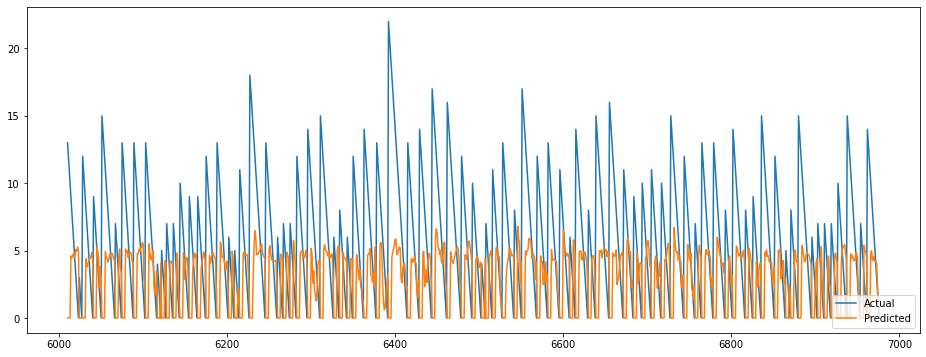

In [34]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal1)
plt.plot(timeLabels, predictedVal1)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

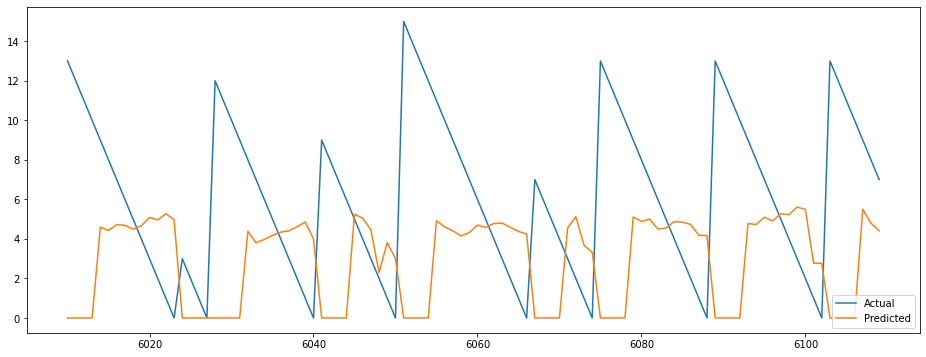

In [35]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal1[0:100])
plt.plot(timeLabels[0:100], predictedVal1[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

### Attempt 2: Add machine state information

In [23]:
(trainX_4step_MS, trainY_4step_MS, trainTime_4step_MS) = splitDataIntoChunks3DWithStateInfo(train_data, 4)
(valX_4step_MS, valY_4step_MS, valTime_4step_MS) = splitDataIntoChunks3DWithStateInfo(val_data, 4)
(testX_4step_MS, testY_4step_MS, testTime_4step_MS) = splitDataIntoChunks3DWithStateInfo(test_data, 4)

In [24]:
#check shape of X (training)
trainX_4step_MS_arr = np.array(trainX_4step_MS)
trainX_4step_MS_arr.shape

(4022, 4, 5)

In [25]:
trainX_4step_MS_arr

array([[[0.37915109, 0.55638519, 0.24307951, 0.22950429, 0.        ],
        [0.41550699, 0.6985611 , 0.24241029, 0.27382456, 1.        ],
        [0.33934205, 0.63764482, 0.23026636, 0.1915881 , 2.        ],
        [0.34381736, 0.627732  , 0.23390451, 0.26456635, 2.        ]],

       [[0.41550699, 0.6985611 , 0.24241029, 0.27382456, 1.        ],
        [0.33934205, 0.63764482, 0.23026636, 0.1915881 , 2.        ],
        [0.34381736, 0.627732  , 0.23390451, 0.26456635, 2.        ],
        [0.31036156, 0.60736811, 0.19429564, 0.2402002 , 2.        ]],

       [[0.33934205, 0.63764482, 0.23026636, 0.1915881 , 2.        ],
        [0.34381736, 0.627732  , 0.23390451, 0.26456635, 2.        ],
        [0.31036156, 0.60736811, 0.19429564, 0.2402002 , 2.        ],
        [0.33632764, 0.53147914, 0.21569348, 0.21578032, 2.        ]],

       ...,

       [[0.36597864, 0.61692472, 0.22676963, 0.24307846, 2.        ],
        [0.37598909, 0.65838067, 0.23041067, 0.18606299, 2.        ],
 

In [26]:
#check shape of y (training)
trainY_4step_MS_arr = np.array(trainY_4step_MS)
trainY_4step_MS_arr = trainY_4step_MS_arr.reshape(-1, 1)
trainY_4step_MS_arr.shape

(4022, 1)

In [27]:
#check shape of X (validation)
valX_4step_MS_arr = np.array(valX_4step_MS)
valX_4step_MS_arr.shape

(635, 4, 5)

In [28]:
#check shape of y (validation)
valY_4step_MS_arr = np.array(valY_4step_MS)
valY_4step_MS_arr = valY_4step_MS_arr.reshape(-1, 1)
valY_4step_MS_arr.shape

(635, 1)

In [35]:
#configure architecture 
model2 = models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(4, 5), padding="same"))
model2.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', padding="same"))
model2.add(layers.MaxPooling1D(pool_size=2, padding='same'))
model2.add(layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Flatten())
model2.add(layers.Dense(100, activation='relu'))
model2.add(layers.Dense(1, activation='relu'))

In [36]:
model2.compile(loss='mean_squared_error', optimizer=adam, metrics=[tf.keras.metrics.MeanSquaredError()])

In [37]:
fileName2 = "CNN_anomalyTest_withTrueStateInfo.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=fileName2,
    save_weights_only=False,
    monitor='val_mean_squared_error',
    mode='min',
    save_best_only=True)

In [38]:
learning_model2 = model2.fit(trainX_4step_MS_arr, trainY_4step_MS_arr, epochs=500, batch_size=32, validation_data=(valX_4step_MS_arr, valY_4step_MS_arr), shuffle=False, callbacks=[model_checkpoint_callback])

Epoch 1/500
126/126 [==============================] - 2s 8ms/step - loss: 20.2554 - mean_squared_error: 20.2554 - val_loss: 6.3472 - val_mean_squared_error: 6.3472
Epoch 2/500
126/126 [==============================] - 1s 5ms/step - loss: 13.9783 - mean_squared_error: 13.9783 - val_loss: 6.0103 - val_mean_squared_error: 6.0103
Epoch 3/500
126/126 [==============================] - 1s 5ms/step - loss: 13.7244 - mean_squared_error: 13.7244 - val_loss: 5.9014 - val_mean_squared_error: 5.9014
Epoch 4/500
126/126 [==============================] - 1s 6ms/step - loss: 13.5001 - mean_squared_error: 13.5001 - val_loss: 5.9999 - val_mean_squared_error: 5.9999
Epoch 5/500
126/126 [==============================] - 1s 5ms/step - loss: 13.2580 - mean_squared_error: 13.2580 - val_loss: 5.8287 - val_mean_squared_error: 5.8287
Epoch 6/500
126/126 [==============================] - 1s 4ms/step - loss: 13.2255 - mean_squared_error: 13.2255 - val_loss: 5.8149 - val_mean_squared_error: 5.8149
Epoch 7/50

Epoch 50/500
126/126 [==============================] - 1s 5ms/step - loss: 12.2438 - mean_squared_error: 12.2438 - val_loss: 7.4100 - val_mean_squared_error: 7.4100
Epoch 51/500
126/126 [==============================] - 1s 5ms/step - loss: 12.2867 - mean_squared_error: 12.2867 - val_loss: 7.1504 - val_mean_squared_error: 7.1504
Epoch 52/500
126/126 [==============================] - 1s 5ms/step - loss: 12.3582 - mean_squared_error: 12.3582 - val_loss: 7.3233 - val_mean_squared_error: 7.3233
Epoch 53/500
126/126 [==============================] - 1s 5ms/step - loss: 12.2592 - mean_squared_error: 12.2592 - val_loss: 7.1791 - val_mean_squared_error: 7.1791
Epoch 54/500
126/126 [==============================] - 1s 5ms/step - loss: 12.2628 - mean_squared_error: 12.2628 - val_loss: 7.4269 - val_mean_squared_error: 7.4269
Epoch 55/500
126/126 [==============================] - 1s 5ms/step - loss: 12.2905 - mean_squared_error: 12.2905 - val_loss: 7.4363 - val_mean_squared_error: 7.4363
Epoc

126/126 [==============================] - 1s 5ms/step - loss: 11.9617 - mean_squared_error: 11.9617 - val_loss: 6.4021 - val_mean_squared_error: 6.4021
Epoch 149/500
126/126 [==============================] - 1s 5ms/step - loss: 11.9491 - mean_squared_error: 11.9491 - val_loss: 6.4196 - val_mean_squared_error: 6.4196
Epoch 150/500
126/126 [==============================] - 1s 5ms/step - loss: 11.9915 - mean_squared_error: 11.9915 - val_loss: 6.3883 - val_mean_squared_error: 6.3883
Epoch 151/500
126/126 [==============================] - 1s 5ms/step - loss: 12.0402 - mean_squared_error: 12.0402 - val_loss: 6.3621 - val_mean_squared_error: 6.3621
Epoch 152/500
126/126 [==============================] - 1s 5ms/step - loss: 11.9446 - mean_squared_error: 11.9446 - val_loss: 6.4311 - val_mean_squared_error: 6.4311
Epoch 153/500
126/126 [==============================] - 1s 5ms/step - loss: 12.0605 - mean_squared_error: 12.0605 - val_loss: 6.5420 - val_mean_squared_error: 6.5420
Epoch 154/50

126/126 [==============================] - 1s 5ms/step - loss: 11.5504 - mean_squared_error: 11.5504 - val_loss: 6.1861 - val_mean_squared_error: 6.1861
Epoch 247/500
126/126 [==============================] - 1s 6ms/step - loss: 11.5227 - mean_squared_error: 11.5227 - val_loss: 6.3424 - val_mean_squared_error: 6.3424
Epoch 248/500
126/126 [==============================] - 1s 5ms/step - loss: 11.5845 - mean_squared_error: 11.5845 - val_loss: 6.3700 - val_mean_squared_error: 6.3700
Epoch 249/500
126/126 [==============================] - 1s 5ms/step - loss: 11.5696 - mean_squared_error: 11.5696 - val_loss: 6.1959 - val_mean_squared_error: 6.1959
Epoch 250/500
126/126 [==============================] - 1s 5ms/step - loss: 11.4281 - mean_squared_error: 11.4281 - val_loss: 6.4380 - val_mean_squared_error: 6.4380
Epoch 251/500
126/126 [==============================] - 1s 5ms/step - loss: 11.5349 - mean_squared_error: 11.5349 - val_loss: 6.2103 - val_mean_squared_error: 6.2103
Epoch 252/50

126/126 [==============================] - 1s 6ms/step - loss: 11.1546 - mean_squared_error: 11.1546 - val_loss: 6.0931 - val_mean_squared_error: 6.0931
Epoch 345/500
126/126 [==============================] - 1s 6ms/step - loss: 11.1182 - mean_squared_error: 11.1182 - val_loss: 6.0915 - val_mean_squared_error: 6.0915
Epoch 346/500
126/126 [==============================] - 1s 6ms/step - loss: 11.1558 - mean_squared_error: 11.1558 - val_loss: 6.2242 - val_mean_squared_error: 6.2242
Epoch 347/500
126/126 [==============================] - 1s 7ms/step - loss: 11.0287 - mean_squared_error: 11.0287 - val_loss: 6.0217 - val_mean_squared_error: 6.0217
Epoch 348/500
126/126 [==============================] - 1s 7ms/step - loss: 11.0297 - mean_squared_error: 11.0297 - val_loss: 6.3869 - val_mean_squared_error: 6.3869
Epoch 349/500
126/126 [==============================] - 1s 6ms/step - loss: 11.1357 - mean_squared_error: 11.1357 - val_loss: 6.0772 - val_mean_squared_error: 6.0772
Epoch 350/50

126/126 [==============================] - 1s 6ms/step - loss: 10.5974 - mean_squared_error: 10.5974 - val_loss: 6.3665 - val_mean_squared_error: 6.3665
Epoch 443/500
126/126 [==============================] - 1s 5ms/step - loss: 10.4598 - mean_squared_error: 10.4598 - val_loss: 6.3546 - val_mean_squared_error: 6.3546
Epoch 444/500
126/126 [==============================] - 1s 6ms/step - loss: 10.5446 - mean_squared_error: 10.5446 - val_loss: 6.3021 - val_mean_squared_error: 6.3021
Epoch 445/500
126/126 [==============================] - 1s 7ms/step - loss: 10.4974 - mean_squared_error: 10.4974 - val_loss: 6.2789 - val_mean_squared_error: 6.2789
Epoch 446/500
126/126 [==============================] - 1s 7ms/step - loss: 10.5703 - mean_squared_error: 10.5703 - val_loss: 6.6623 - val_mean_squared_error: 6.6623
Epoch 447/500
126/126 [==============================] - 1s 7ms/step - loss: 10.4084 - mean_squared_error: 10.4084 - val_loss: 6.3415 - val_mean_squared_error: 6.3415
Epoch 448/50

In [29]:
model2 = tf.keras.models.load_model('CNN_anomalyTest_withTrueStateInfo.h5')

In [30]:
#performance on training set
trainPredict2 = model2.predict(trainX_4step_MS_arr)
# calculate root mean squared error
trainScore2 = math.sqrt(mean_squared_error(trainY_4step_MS_arr, trainPredict2))
trainR2Score2 = r2_score(trainY_4step_MS_arr, trainPredict2)
trainSscore2 = findSscore(trainY_4step_arr, trainPredict2)
print('Train Score: %.4f RMSE %.4f R2 Score %.4f S score' % (trainScore2, trainR2Score2, trainSscore2))

Train Score: 3.5578 RMSE 0.3220 R2 Score 5126.9170 S score


In [31]:
#performance on validation set
valPredict2 = model2.predict(valX_4step_MS_arr)
# calculate root mean squared error
valScore2 = math.sqrt(mean_squared_error(valY_4step_MS_arr, valPredict2))
valR2Score2 = r2_score(valY_4step_MS_arr, valPredict2)
valSscore2 = findSscore(valY_4step_arr, valPredict2)
print('Validation Score: %.4f RMSE %.4f R2 Score %.4f S score' % (valScore2, valR2Score2, valSscore2))

Validation Score: 2.4114 RMSE 0.4924 R2 Score 762.9987 S score


In [45]:
allRUL = all_df['RUL']
(actualVal2, predictedVal2) = getRULValues(valPredict2, allRUL, valTime_4step_MS, 6010, 6976)

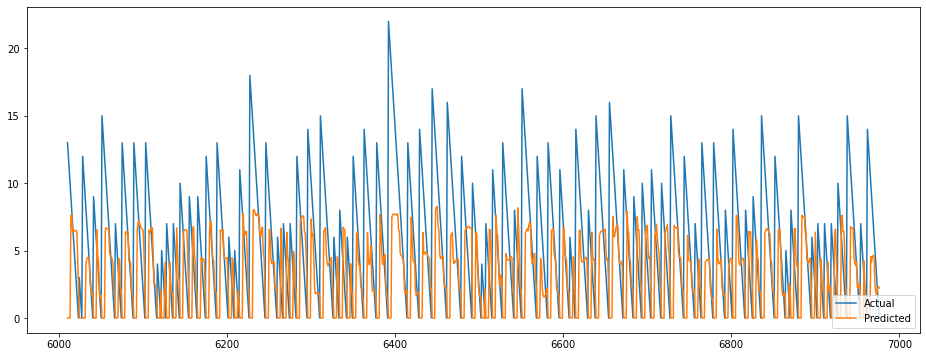

In [47]:
#validation set
timeLabels = [i for i in range(6010, 6977)]
plt.figure(figsize=(16, 6))
plt.plot(timeLabels, actualVal2)
plt.plot(timeLabels, predictedVal2)
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()

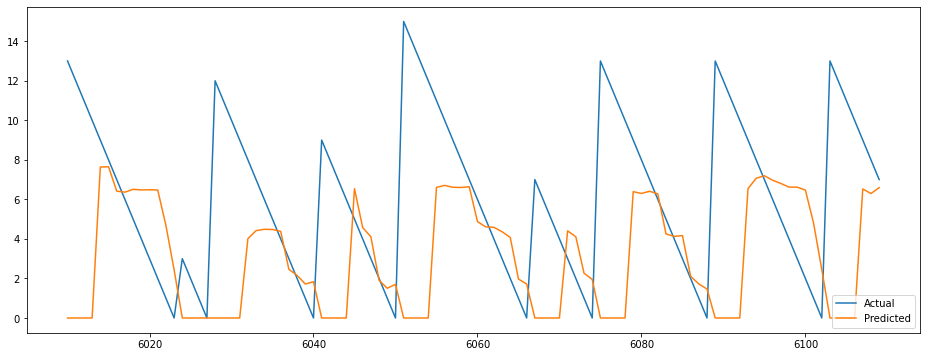

In [48]:
plt.figure(figsize=(16, 6))
plt.plot(timeLabels[0:100], actualVal2[0:100])
plt.plot(timeLabels[0:100], predictedVal2[0:100])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()